In [1]:
from app_hawkes import *
import numpy as np

In [366]:
# Constants
C = 0.617
D = 0.446
m1 = 0
m2 = 1
num_iter = 10
alpha = 0.05
T = 10240

# A_list = [np.array([
#     [0.5, 0.0, 0.3],
#     [0.0, 0.5, -0.3],
#     [0.3, -0.3, 0.5]
# ])]

A_list = [np.array([
    [0.3, 0.0, 0.4, -0.2, 0.2],
    [0.0, 0.3, 0.2, 0.2, 0.2],
    [0.2, 0.2, 0.3, -0.2, 0.2],
    [-0.2, 0.2, -0.2, 0.3, 0.2],
    [0.2, -0.2, 0.2, 0.2, 0.5]
])]

In [400]:
from joblib import Parallel, delayed
from tqdm import tqdm

def process_item(item):
    # Generate time series
    x = generate_var_process(A_list, T, 1000, seed=None)
    x = x - np.mean(x, axis=1, keepdims=True)
    
    # m_range = np.arange(900, 1100, 2)
    # _, m = find_best_m(x, m_range)
    
    m = 2000
    
    _, T_0, _ = calculate_freq_avg_periodogram(x, m)
    
    all_edge_removed = set()
    
    E = {(0,1)}
    
    _, _, test_stat = calculate_test_stat(T_0, all_edge_removed, E, m,
                                                              T, C, D, m1, m2, num_iter)
    return test_stat

items = range(5000)  # Example list of items to process

# Parallelize the for loop
results = Parallel(n_jobs=-1)(delayed(process_item)(item) for item in tqdm(items, desc="Processing items"))

Processing items: 100%|██████████| 5000/5000 [09:57<00:00,  8.37it/s]


In [396]:
process_item('i')

np.complex128(4.682948628835402+2.728986387288146e-16j)

In [397]:
process_item('i')

np.complex128(3.734298949994922-9.01324847272654e-17j)

In [401]:
new_results = np.real(results)

In [402]:
# Convert NumPy array to DataFrame
# df = pd.DataFrame(new_results, columns=['Value', "M_value"])
df = pd.DataFrame(new_results, columns=['Value'])

# Save DataFrame to CSV
df.to_csv('../simulations_data/5x5_5000_samples_m=2000_T=10240.csv', index=False)

In [310]:
# Separate the list of tuples into individual lists
test_stats, m_values = zip(*results)

# Convert the zipped objects to lists
test_stats = np.real(list(test_stats))
m_values = list(m_values)

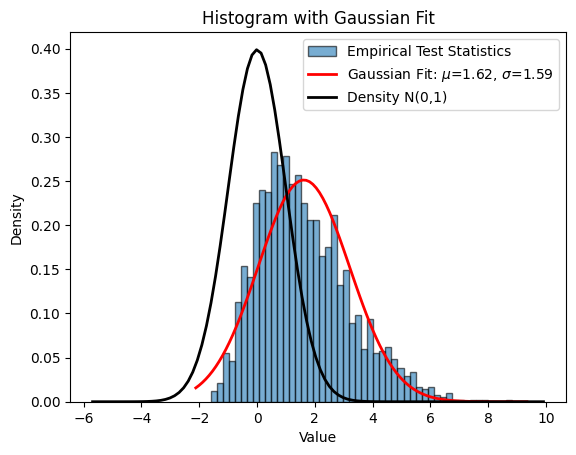

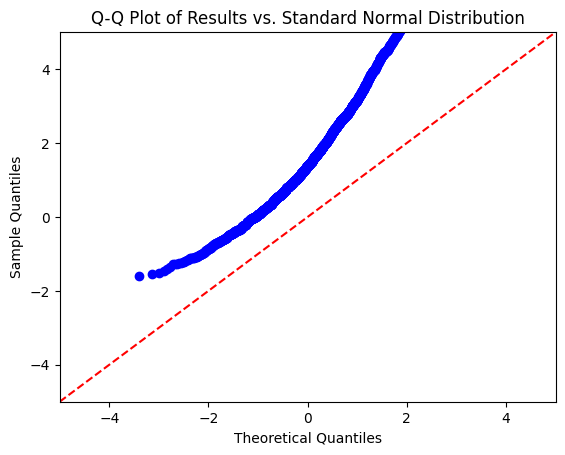

In [311]:
import numpy as np
from scipy.stats import norm, probplot

new_results = np.real(results)
# Calculate mean and standard deviation (which is the square root of variance)
mean_result = np.mean(test_stats)
std_result = np.std(test_stats)

# Plot a histogram of the results
plt.hist(test_stats, bins=50, edgecolor='black', density=True, alpha=0.6, label='Empirical Test Statistics')

# Plot the Gaussian distribution using mean and std from the data
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_result, std_result)
plt.plot(x, p, 'r', linewidth=2, label=f'Gaussian Fit: $\mu$={mean_result:.2f}, $\sigma$={std_result:.2f}')


# Add a line representing the density of a normal distribution (mean=0, std=1)
xmin, xmax = plt.xlim()
x = np.linspace(xmin-3, xmax, 100)
p = norm.pdf(x, 0, 1)
plt.plot(x, p, 'k', linewidth=2, label = f'Density N(0,1)')

# Add titles, labels, and legend
plt.title('Histogram with Gaussian Fit')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()


# Q-Q plot of results vs. standard normal distribution
plt.figure()
probplot(test_stats, dist="norm", plot=plt, fit=False)

# Add titles and labels to the Q-Q plot
plt.title('Q-Q Plot of Results vs. Standard Normal Distribution')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Set x and y-axis limits
plt.xlim(-5, 5)
plt.ylim(-5, 5)

# Plot a manual red line from (-5, -5) to (5, 5)
plt.plot([-5, 5], [-5, 5], 'r--')

# Show the Q-Q plot
plt.show()

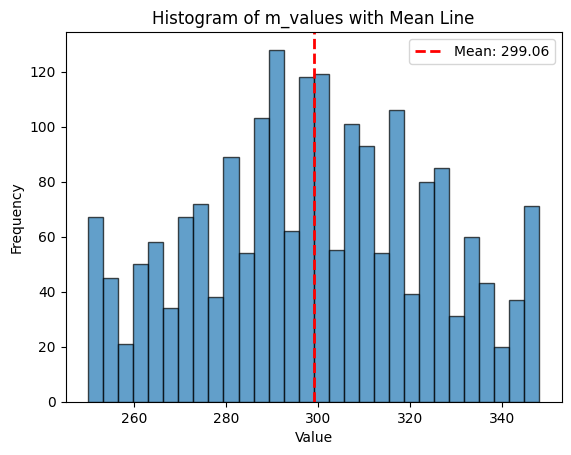

In [312]:
# Plot the histogram
plt.hist(m_values, bins=30, edgecolor='black', alpha=0.7)

# Calculate the mean
mean_value = np.mean(m_values)

# Add a vertical line at the mean
plt.axvline(mean_value, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')

# Add titles and labels
plt.title('Histogram of m_values with Mean Line')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

In [313]:
# Calculate the skewness
skewness = stats.skew(test_stats)

# Print the skewness
print(f'Skewness of the data: {skewness:.2f}')

# Compare with standard normal distribution
if skewness == 0:
    print("The distribution is symmetrical (similar to a standard normal distribution).")
elif skewness > 0:
    print("The distribution is positively skewed (right tail is longer).")
else:
    print("The distribution is negatively skewed (left tail is longer).")

Skewness of the data: 0.72
The distribution is positively skewed (right tail is longer).


# Third algorithm


In [286]:
def diagonal_up_weighting(spectral_matrices, zeta):
    """
    Apply the matrix diagonal up-weighting scheme to an array of spectral matrices.

    Parameters:
    spectral_matrices (numpy.ndarray): Array of spectral matrices with shape (p, p, num_frequencies)
    zeta (float): Up-weighting parameter

    Returns:
    numpy.ndarray: New array of up-weighted spectral matrices
    """
    # Matrix dimensions and number of frequencies
    p, _, num_frequencies = spectral_matrices.shape

    # Step 1: Evaluate the maximum value of each diagonal element over the frequency range
    max_diagonal_elements = np.max([spectral_matrices[i, i, :] for i in range(p)], axis=1)
    
    # Step 2: Arrange the maximum values into a diagonal matrix A
    A = np.diag(max_diagonal_elements)
    
    # Step 3: Multiply A by zeta to get B
    B = zeta * A
    
    # Step 4: Add B to each spectral matrix
    new_spectral_matrices = spectral_matrices + B[:, :, np.newaxis]

    return new_spectral_matrices

def calculate_critical_region_minmax(alpha, L, l, n, p):
    """
    Calculate the critical region for partial coherence estimator.

    Parameters:
    alpha (float): Significance level.
    L (int): Total number of frequency bins.
    l (int): Current frequency bin index (1-based).
    n (int): Number of complex degrees of freedom.
    p (int): Number of time series.

    Returns:
    float: The critical value C_l.
    """
    # Calculate the critical region value C_l using the provided formula (19)
    exponent = 1 / (L - l + 1)
    base = 1 - alpha
    inner_term = 1 - base ** exponent
    critical_value = 1 - (inner_term ** (1 / (n - p + 1)))

    return critical_value

def calculate_critical_region_holm(alpha, L, l, n, p):
    """
    Calculate Holm's critical region for multiple hypothesis testing.

    Parameters:
    alpha (float): Significance level.
    L (int): Total number of tests (frequency bins).
    l (int): Current test index (1-based).
    n (int): Number of complex degrees of freedom.
    p (int): Number of time series.

    Returns:
    float: Holm's critical value for the given test index.
    """
    fraction = alpha / (L - l + 1)
    holm_critical_value = 1 - (fraction) ** (1/(n - p + 1))
    print(holm_critical_value)
    return holm_critical_value

def maximin_stepdown_test(partial_coherence, alpha, n):
    """
    Perform the maximin stepdown hypothesis testing procedure.

    Parameters:
    coherence_matrix (numpy.ndarray): Coherence matrix with shape (p, p, num_freq).
    alpha (float): Significance level.
    n (int): Number of complex degrees of freedom (tapers)
    p (int): Number of time series.
    m (int): Number of tapers.

    Returns:
    int: Number of hypotheses under the critical value.
    """
    num_series, _, num_frequencies = partial_coherence.shape
    
    
    # Initialize an array to store the critical values for each frequency bin
    critical_values = np.zeros(num_frequencies)
    
    array = np.arange(num_frequencies)
    
    # Calculate critical values for each frequency bin
    for l in range(1, num_frequencies + 1):
        critical_values[l - 1] = calculate_critical_region_minmax(alpha, num_frequencies, l, n, num_series)
        
    critical_values_holm = np.zeros(num_frequencies)
    # Calculate critical values for each frequency bin
    for l in range(1, num_frequencies + 1):
        critical_values_holm[l - 1] = calculate_critical_region_holm(alpha, num_frequencies, l, n, num_series)
        
    final = dict()
    
    print(critical_values_holm)
    
    
    for j in range(num_series):
        for k in range(j + 1, num_series):  # Only consider upper triangular entries (j < k)
            R_l = partial_coherence[j, k, :]
            R_ordered = np.sort(R_l)[::-1]
            comparison = R_ordered > critical_values # if positive that means there is an edge
            comparison = np.sum(comparison)
            final[(j,k)] = np.round(comparison / num_frequencies, 2)
            
            plt.plot(array, R_ordered)
            plt.plot(array, critical_values)
            plt.plot(array, critical_values_holm)
            plt.show()
            # print(f'({j},{k}): {comparison}')

    return final

In [298]:
A_list = [np.array([
    [0.5, 0.0, 0.3],
    [0.0, 0.5, -0.3],
    [0.3, -0.3, 0.5]
])]

# A_list = [np.array([
#     [0.5, 0.0, 0.3],
#     [0.0, 0.0, 0.7],
#     [0.3, 0.0, 0.5]
# ])]

# Generate time series
x = generate_var_process(A_list, T, 1000, seed=None)
x = x - np.mean(x, axis=1, keepdims=True)

# m_range = np.arange(60, 200, 2)
# _, m = find_best_m(x, m_range)

m = 30

frequencies, T_0 = sinusoidal_multitaper_sdf_matrix(x, m)

In [299]:
new_T_0 = diagonal_up_weighting(T_0, 1e-6)

In [300]:
plot_sdf_with_theoretical(frequencies, [new_T_0], ['Upweight'], T_0, log_scale=False,
                          function=np.abs, different_frequencies=None)

In [301]:
coherence_0 = calculate_partial_coherence(T_0)
coherence_1 = calculate_partial_coherence(new_T_0)

0.28092365620647697
0.28087344662140945
0.2808231351663394
0.2807727214342294
0.2807222050156114
0.2806715854985685
0.28062086246871465
0.28057003550917503
0.28051910420056647
0.28046806812097713
0.2804169268459462
0.2803656799484433
0.28031432699884795
0.2802628675649286
0.28021130121182136
0.28015962750200873
0.28010784599529814
0.28005595624879975
0.28000395781690524
0.27995185025126446
0.27989963310076416
0.2798473059115043
0.2797948682267758
0.279742319587037
0.2796896595298902
0.27963688759005867
0.2795840032993617
0.27953100618669147
0.2794778957779882
0.2794246715962153
0.279371333161335
0.2793178799902828
0.2792643115969421
0.27921062749211867
0.27915682718351464
0.2791029101757022
0.279048875970097
0.2789947240649314
0.27894045395522793
0.27888606513277103
0.27883155708608
0.2787769293003808
0.27872218125757786
0.2786673124362259
0.2786123223115001
0.27855721035516834
0.27850197603556004
0.27844661881753796
0.2783911381624672
0.2783355335281845
0.2782798043689684
0.2782239501

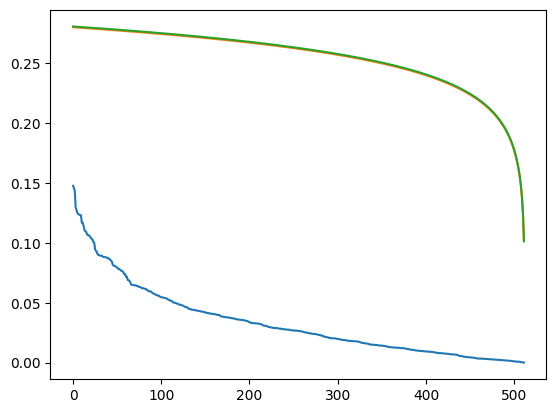

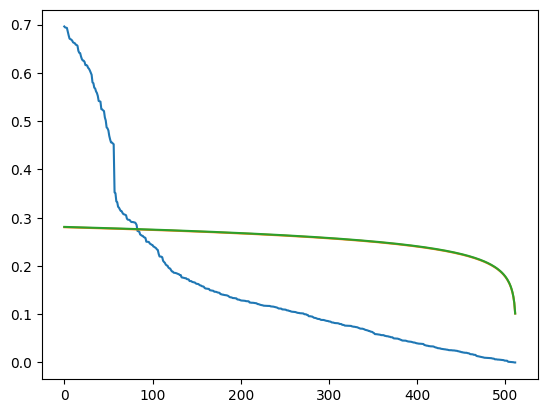

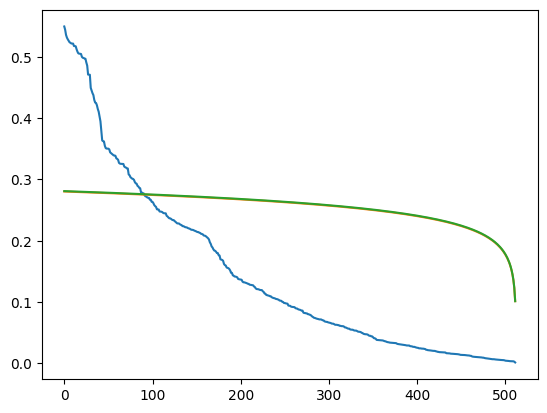

{(0, 1): np.float64(0.0), (0, 2): np.float64(0.16), (1, 2): np.float64(0.18)}

In [302]:
maximin_stepdown_test(coherence_0, 0.05, m)

In [297]:
plot_sdf_with_theoretical(frequencies, [coherence_1], ['Upweight'], coherence_0, log_scale=False,
                          function=np.abs, different_frequencies=None)

In [251]:
calculate_critical_region_minmax(0.05, 512, 100, 20, 5)

0.42999295508859026

0.6847083237764097
0.6846312635845262
0.6845540335525205
0.6844766329719436
0.6843990611299917
0.6843213173094718
0.6842434007887649
0.6841653108417909
0.6840870467379714
0.684008607742193
0.6839299931147702
0.6838512021114076
0.683772233983162
0.6836930879764045
0.6836137633327806
0.6835342592891718
0.6834545750776564
0.6833747099254683
0.6832946630549577
0.6832144336835497
0.6831340210237032
0.6830534242828692
0.6829726426634486
0.68289167536275
0.682810521572946
0.6827291804810305
0.6826476512687741
0.6825659331126805
0.6824840251839408
0.6824019266483887
0.6823196366664546
0.6822371543931193
0.6821544789778671
0.6820716095646384
0.6819885452917825
0.6819052852920087
0.6818218286923374
0.6817381746140514
0.6816543221726453
0.6815702704777755
0.6814860186332091
0.6814015657367724
0.6813169108802986
0.6812320531495755
0.6811469916242918
0.6810617253779842
0.6809762534779815
0.6808905749853511
0.6808046889548423
0.6807185944348308
0.6806322904672613
0.6805457760875901
0.680459050324727

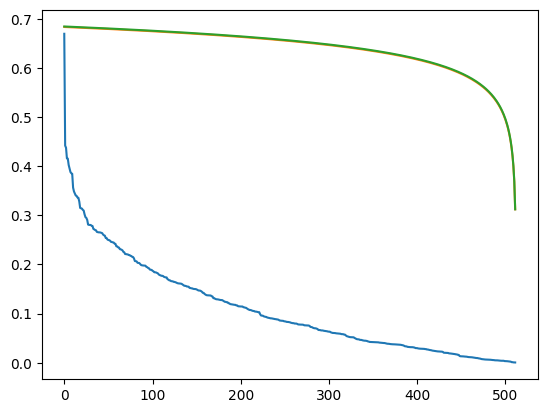

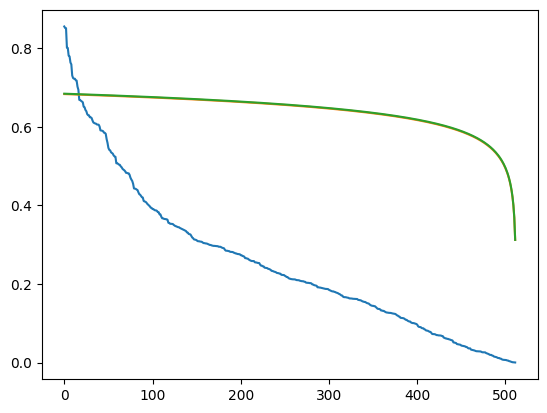

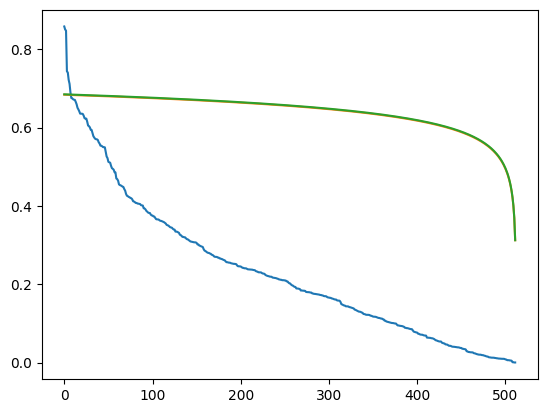

{(0, 1): np.float64(0.0), (0, 2): np.float64(0.03), (1, 2): np.float64(0.02)}

In [252]:
maximin_stepdown_test(coherence_0, 0.05, m)

m=10
0.6847083237764097
0.6846312635845262
0.6845540335525205
0.6844766329719436
0.6843990611299917
0.6843213173094718
0.6842434007887649
0.6841653108417909
0.6840870467379714
0.684008607742193
0.6839299931147702
0.6838512021114076
0.683772233983162
0.6836930879764045
0.6836137633327806
0.6835342592891718
0.6834545750776564
0.6833747099254683
0.6832946630549577
0.6832144336835497
0.6831340210237032
0.6830534242828692
0.6829726426634486
0.68289167536275
0.682810521572946
0.6827291804810305
0.6826476512687741
0.6825659331126805
0.6824840251839408
0.6824019266483887
0.6823196366664546
0.6822371543931193
0.6821544789778671
0.6820716095646384
0.6819885452917825
0.6819052852920087
0.6818218286923374
0.6817381746140514
0.6816543221726453
0.6815702704777755
0.6814860186332091
0.6814015657367724
0.6813169108802986
0.6812320531495755
0.6811469916242918
0.6810617253779842
0.6809762534779815
0.6808905749853511
0.6808046889548423
0.6807185944348308
0.6806322904672613
0.6805457760875901
0.6804590503

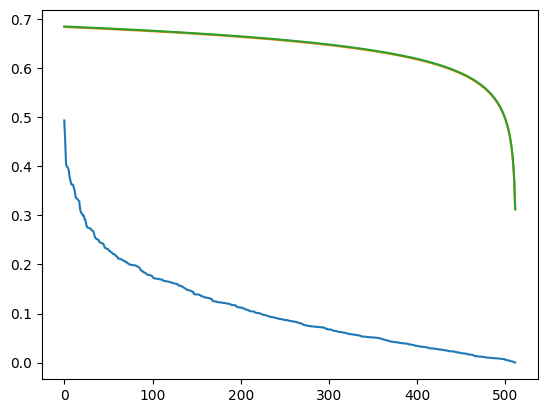

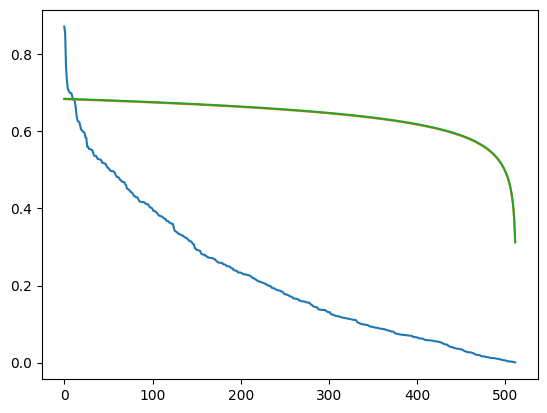

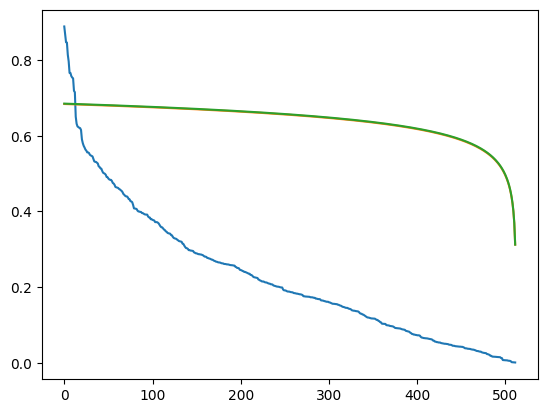

{(0, 1): np.float64(0.0), (0, 2): np.float64(0.02), (1, 2): np.float64(0.03)}
-------
m=20
0.40130510089157834
0.4012400712832339
0.40117490720644255
0.40110960811866714
0.40104417347411003
0.4009786027236877
0.4009128953150036
0.4008470506923223
0.4007810682965419
0.4007149475651677
0.40064868793228425
0.40058228882852787
0.40051574968105896
0.40044906991353324
0.40038224894607355
0.40031528619524115
0.4002481810740065
0.40018093299171975
0.4001135413540813
0.40004600556311154
0.39997832501712094
0.3999104991106788
0.3998425272345828
0.3997744087758279
0.39970614311757424
0.3996377296391155
0.39956916771584683
0.39950045671923207
0.3994315960167708
0.3993625849719652
0.3992934229442864
0.39922410928914076
0.3991546433578351
0.39908502449754246
0.39901525205126676
0.39894532535780747
0.398875243751724
0.3988050065632992
0.39873461311850333
0.3986640627389565
0.3985933547418916
0.39852248844011684
0.3984514631419771
0.3983802781513156
0.3983089327674353
0.39823742628505887
0.39816575799

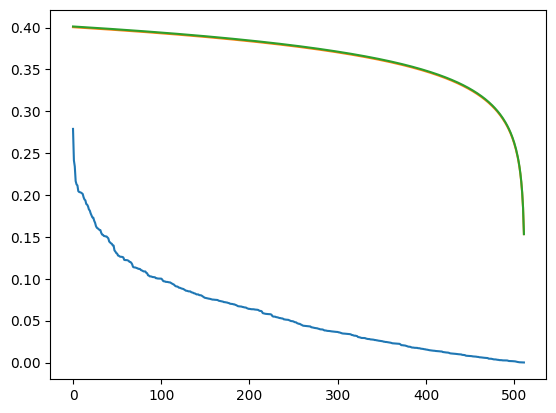

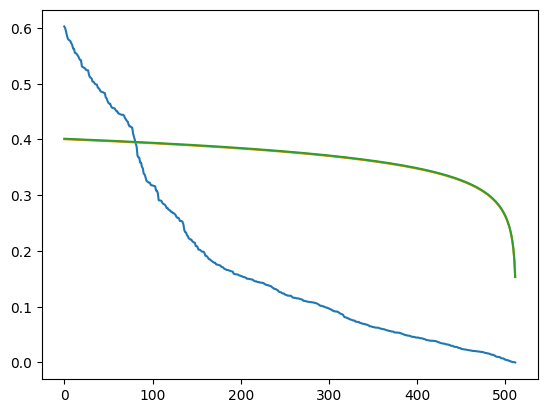

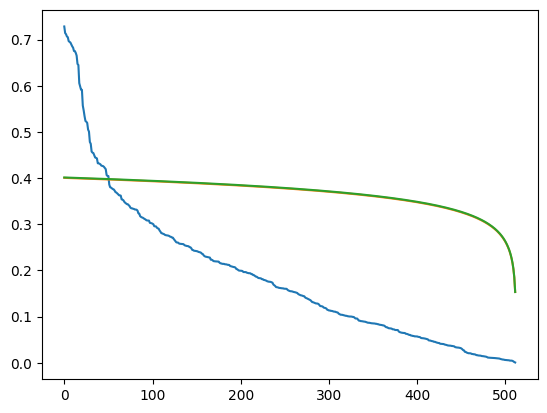

{(0, 1): np.float64(0.0), (0, 2): np.float64(0.16), (1, 2): np.float64(0.1)}
-------
m=50
0.17500354150282316
0.17496993880151523
0.17493626890436165
0.17490253154483726
0.17486872645483387
0.17483485336464688
0.17480091200296344
0.17476690209684942
0.174732823371736
0.17469867555140728
0.17466445835798672
0.17463017151192406
0.1745958147319816
0.17456138773522067
0.1745268902369883
0.1744923219509028
0.1744576825888402
0.1744229718609197
0.17438818947548973
0.17435333513911366
0.17431840855655456
0.17428340943076115
0.17424833746285262
0.17421319235210353
0.17417797379592892
0.17414268148986878
0.17410731512757227
0.17407187440078276
0.17403635899932135
0.1740007686110714
0.17396510292196166
0.17392936161595107
0.17389354437501092
0.17385765087910954
0.1738216808061943
0.17378563383217538
0.17374950963090818
0.17371330787417616
0.17367702823167308
0.17364067037098552
0.17360423395757474
0.1735677186547584
0.17353112412369265
0.1734944500233535
0.17345769601051786
0.1734208617397448
0.

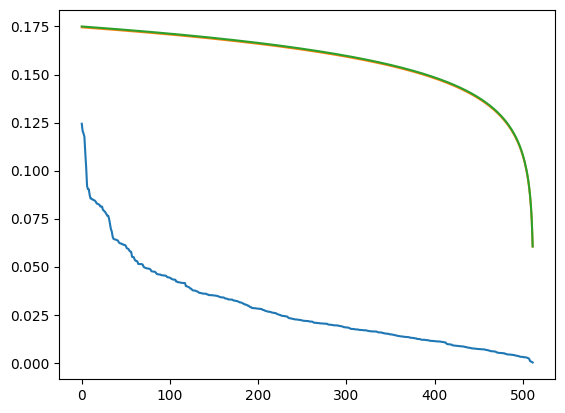

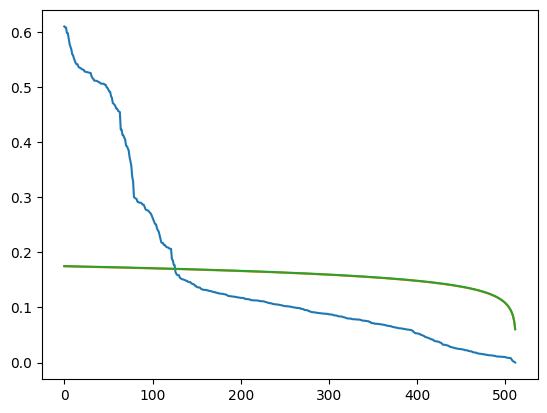

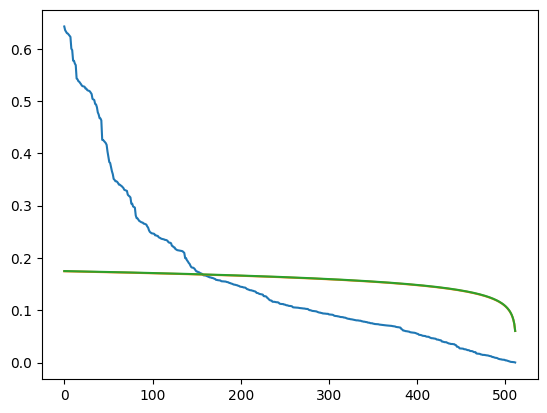

{(0, 1): np.float64(0.0), (0, 2): np.float64(0.25), (1, 2): np.float64(0.31)}
-------
m=100
0.08992209240478755
0.08990393677458308
0.08988574521668691
0.08986751758934641
0.08984925374997044
0.08983095355512172
0.08981261686051056
0.08979424352098786
0.08977583339053885
0.08975738632227548
0.08973890216842983
0.08972038078034705
0.0897018220084781
0.08968322570237286
0.08966459171067265
0.08964591988110282
0.08962721006046559
0.08960846209463247
0.08958967582853683
0.08957085110616603
0.08955198777055384
0.08953308566377272
0.08951414462692608
0.08949516450013983
0.08947614512255497
0.08945708633231919
0.08943798796657865
0.08941884986146975
0.08939967185211084
0.08938045377259363
0.08936119545597498
0.08934189673426784
0.08932255743843287
0.08930317739836946
0.08928375644290687
0.08926429439979533
0.08924479109569694
0.08922524635617646
0.08920566000569174
0.08918603186758511
0.089166361764073
0.08914664951623719
0.08912689494401427
0.08910709786618687
0.08908725810037288
0.089067375

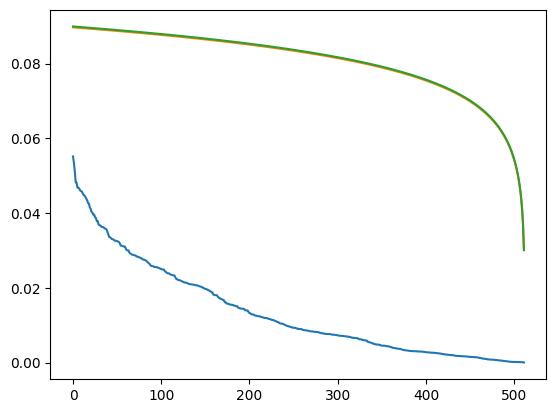

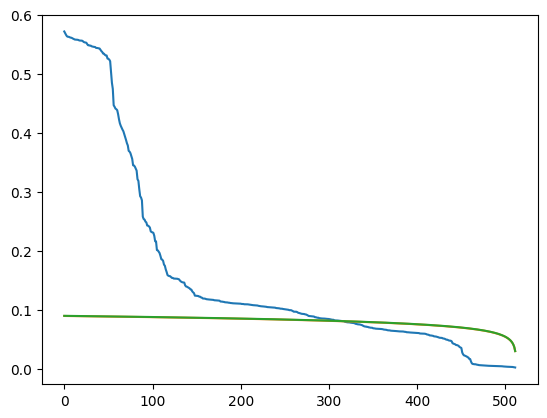

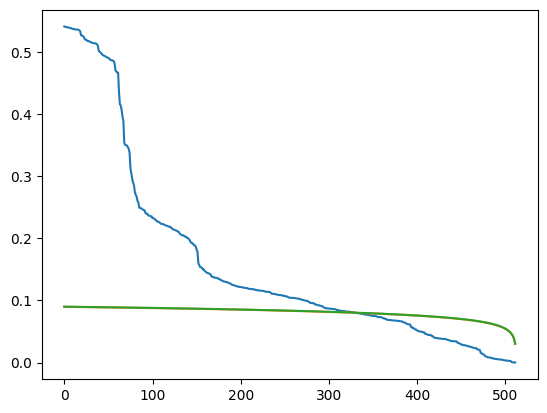

{(0, 1): np.float64(0.0), (0, 2): np.float64(0.62), (1, 2): np.float64(0.64)}
-------
m=200
0.04556587272253432
0.04555644867617337
0.045547006076050556
0.04553754484915029
0.045528064922025435
0.04551856622079398
0.04550904867113548
0.04549951219828796
0.04548995672704381
0.04548038218174677
0.04547078848628794
0.04546117556410256
0.04545154333816592
0.045441891730990336
0.04543222066462049
0.04542253006063057
0.04541281984012002
0.04540308992370956
0.04539334023153774
0.045383570683256824
0.045373781198028595
0.045363971694521
0.04535414209090316
0.04534429230484227
0.04533442225349882
0.0453245318535227
0.045314621021049106
0.045304689671693876
0.045294737720549594
0.045284765082181266
0.04527477167062155
0.04526475739936675
0.04525472218137194
0.04524466592904708
0.045234588554251554
0.04522448996829054
0.04521437008190954
0.04520422880528996
0.04519406604804466
0.045183881719212504
0.04517367572725406
0.04516344798004657
0.04515319838487852
0.04514292684844545
0.045132633276844136

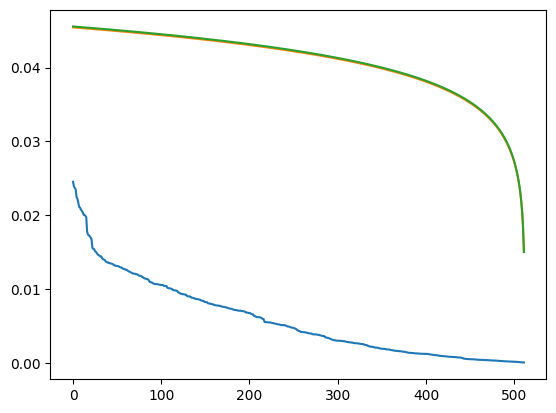

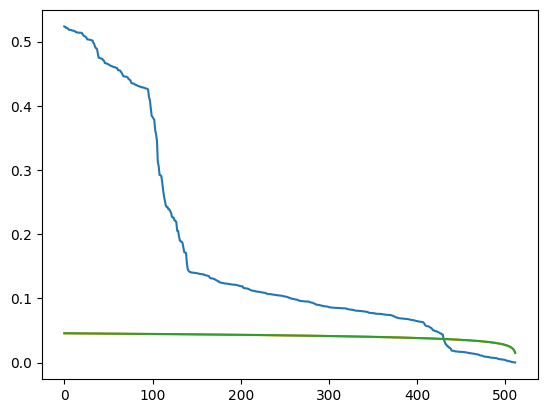

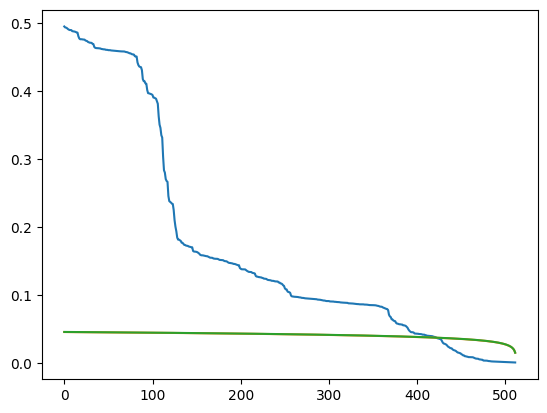

{(0, 1): np.float64(0.0), (0, 2): np.float64(0.84), (1, 2): np.float64(0.82)}
-------
m=300
0.03051159885086363
0.030505238482358532
0.030498865612899384
0.03049248019333206
0.030486082174212337
0.03047967150580322
0.03047324813807295
0.030466812020692347
0.030460363103032684
0.030453901334163147
0.03044742666284883
0.03044093903754752
0.030434438406408026
0.030427924717267407
0.030421397917648307
0.030414857954756624
0.030408304775478845
0.0304017383263796
0.03039515855369901
0.030388565403349888
0.030381958820915322
0.030375338751645886
0.030368705140456753
0.030362057931925368
0.030355397070288226
0.03034872249943832
0.03034203416292236
0.030335332003937787
0.030328615965329875
0.03032188598958896
0.03031514201884733
0.03030838399487623
0.0303016118590832
0.03029482555250862
0.030288025015822728
0.030281210189322727
0.030274381012929563
0.030267537426184488
0.03026067936824628
0.030253806777887693
0.03024691959349246
0.030240017753051518
0.030233101194160228
0.030226169854014828
0.0

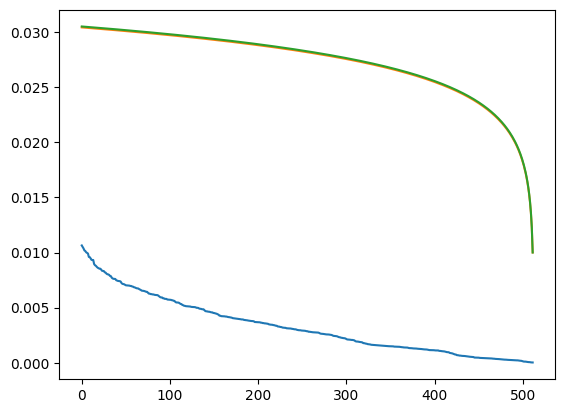

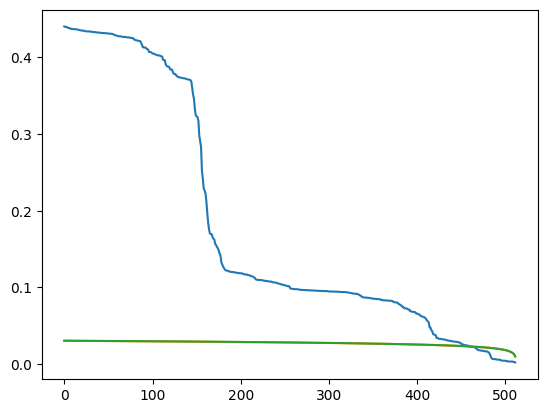

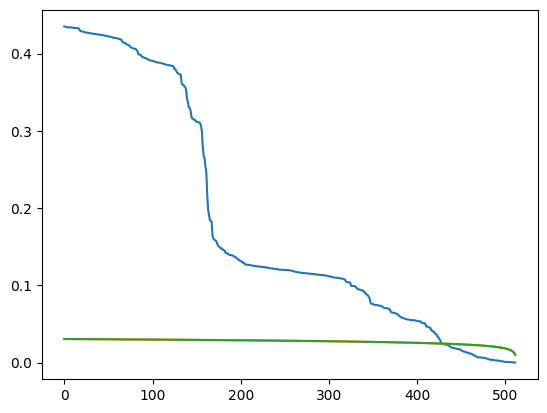

{(0, 1): np.float64(0.0), (0, 2): np.float64(0.9), (1, 2): np.float64(0.84)}
-------
m=400
0.02293407083858867
0.022929271334518386
0.022924462405221835
0.022919644013654317
0.02291481612255264
0.02290997869443312
0.022905131691589697
0.02290027507609249
0.0228954088097858
0.02289053285428666
0.022885647170982293
0.02288075172102899
0.022875846465350236
0.02287093136463425
0.02286600637933256
0.022861071469658212
0.02285612659558356
0.022851171716838148
0.022846206792907275
0.02284123178302977
0.02283624664619588
0.022831251341145276
0.022826245826365055
0.02282123006008785
0.022816204000289275
0.022811167604686378
0.0228061208307353
0.022801063635628727
0.022795995976294336
0.022790917809392353
0.022785829091313103
0.022780729778175246
0.02277561982582288
0.02277049918982388
0.02276536782546723
0.022760225687760927
0.02275507273142907
0.022749908910910333
0.02274473418035472
0.022739548493621697
0.02273435180427752
0.022729144065592566
0.022723925230539344
0.022718695251789267
0.02271

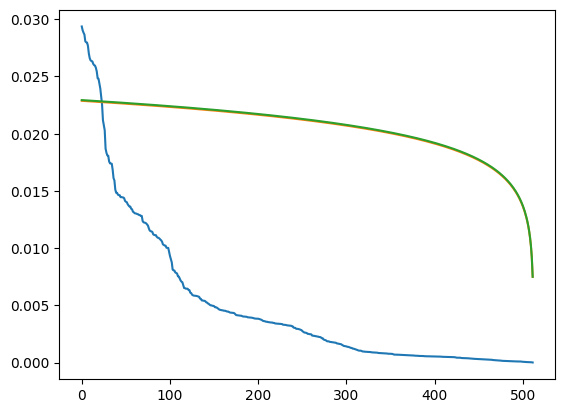

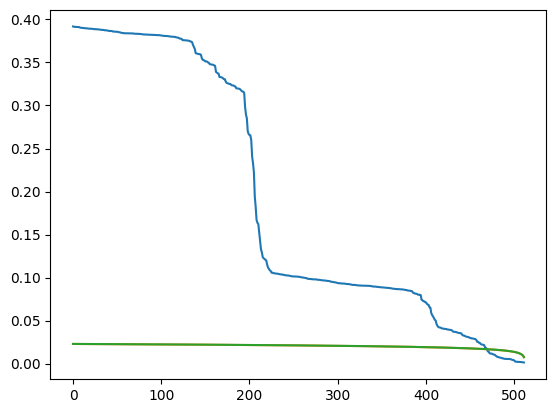

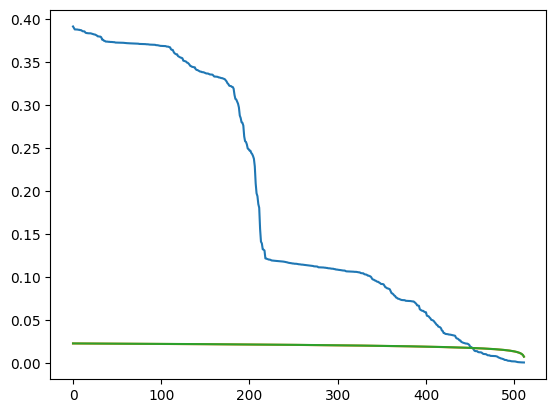

{(0, 1): np.float64(0.04), (0, 2): np.float64(0.92), (1, 2): np.float64(0.88)}
-------


In [253]:
# Generate time series
alpha = 0.05
x = generate_var_process(A_list, T, 1000, seed=None)
x = x - np.mean(x, axis=1, keepdims=True)


m_list = [10, 20, 50, 100, 200, 300, 400]
for m in m_list:
    print(f'm={m}')
    frequencies, T_0 = sinusoidal_multitaper_sdf_matrix(x, m)
    coherence_0 = calculate_partial_coherence(T_0)
    y = maximin_stepdown_test(coherence_0, alpha, m)
    print(y)
    print('-------')
    
    

In [343]:
def split_filename(filename):
    # Split the filename on "_"
    parts = filename.split("_")
    
    # Remove the last part (which is "2048.csv") and split again to discard ".csv"
    parts_without_extension = parts[:-1] + [parts[-1].split(".")[0]]
    
    num_time_series = int(parts_without_extension[0][0])
    num_simulatons = int(parts_without_extension[1])
    T = int(parts_without_extension[-1].split("=")[-1])
    m_value = parts_without_extension[-2].split("=")[-1]
    if m_value == 'variable':
        m_value = None
    else:
        m_value = int(m_value)
    
    return num_time_series, num_simulatons, T, m_value

In [342]:
file_path = '5x5_2000_samples_m=variable_T=2048.csv'
split_filename(file_path)

(5, 2000, 2048, 10)